In [ ]:

import kagglehub
hbchaitanyabharadwaj_audio_dataset_with_10_indian_languages_path = kagglehub.dataset_download('hbchaitanyabharadwaj/audio-dataset-with-10-indian-languages')

print(f"Dataset downloaded to: {hbchaitanyabharadwaj_audio_dataset_with_10_indian_languages_path}")


Dataset downloaded to: /kaggle/input/audio-dataset-with-10-indian-languages


In [ ]:
!pip install librosa torchaudio scikit-learn matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import os
import random
import torch
import torchaudio
import numpy as np
import librosa
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Settings
DATA_DIR = "/content/drive/MyDrive/processed_dataset"
SAMPLE_RATE = 16000
FIXED_LENGTH = SAMPLE_RATE * 4  # 4 seconds
RANDOM_STATE = 42
EXCLUDED_LABEL = "punjabi"

# Util: Preprocess single audio
def preprocess_audio(filepath):
    y, sr = librosa.load(filepath, sr=SAMPLE_RATE)
    y, _ = librosa.effects.trim(y, top_db=20)  # Trim silence
    y = librosa.util.normalize(y)              # Normalize volume
    if len(y) > FIXED_LENGTH:
        y = y[:FIXED_LENGTH]
    else:
        y = np.pad(y, (0, FIXED_LENGTH - len(y)))
    return torch.tensor(y, dtype=torch.float32)

# Dataset Parsing
all_files = glob(os.path.join(DATA_DIR, "*.mp3"))
data = [(f, os.path.basename(f).split("_")[0]) for f in all_files]
data = [d for d in data if d[1].lower() != EXCLUDED_LABEL]

# Labels
labels = sorted(set(label for _, label in data))
label2idx = {label: i for i, label in enumerate(labels)}



In [ ]:
# Splitting
random.seed(RANDOM_STATE)
random.shuffle(data)
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=RANDOM_STATE)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=RANDOM_STATE)

# Dataset Class
class AudioDataset(Dataset):
    def __init__(self, data, label2idx):
        self.data = data
        self.label2idx = label2idx

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        filepath, label = self.data[idx]
        waveform = preprocess_audio(filepath)
        label_idx = self.label2idx[label]
        return waveform.unsqueeze(0), label_idx  # [1, T]



In [ ]:
# Dataloaders
BATCH_SIZE = 32
train_loader = DataLoader(AudioDataset(train_data, label2idx), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(AudioDataset(val_data, label2idx), batch_size=BATCH_SIZE)
test_loader = DataLoader(AudioDataset(test_data, label2idx), batch_size=BATCH_SIZE)

# CNN Model
class CNN1D(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)




In [ ]:
def train_model(model, train_loader, val_loader, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    train_acc_list = []
    val_acc_list = []

    for epoch in range(epochs):
        model.train()
        correct_train, total_train = 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            preds = torch.argmax(out, dim=1)
            correct_train += (preds == y).sum().item()
            total_train += y.size(0)

        train_acc = correct_train / total_train
        train_acc_list.append(train_acc)

        # Validation
        model.eval()
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                preds = torch.argmax(out, dim=1)
                correct_val += (preds == y).sum().item()
                total_val += y.size(0)

        val_acc = correct_val / total_val
        val_acc_list.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

    # Plot accuracy
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs + 1), train_acc_list, label="Train Accuracy")
    plt.plot(range(1, epochs + 1), val_acc_list, label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
# Evaluation
def evaluate_model(model, loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out = model(x)
            preds = torch.argmax(out, dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(y.numpy())
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")
    print(f"Test Accuracy: {acc:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=label2idx.keys()).plot(xticks_rotation=45)
    plt.show()

Epoch 1/100: Train Acc = 0.1257, Val Acc = 0.1000
Epoch 2/100: Train Acc = 0.1620, Val Acc = 0.1778
Epoch 3/100: Train Acc = 0.1788, Val Acc = 0.1556
Epoch 4/100: Train Acc = 0.1969, Val Acc = 0.2222
Epoch 5/100: Train Acc = 0.2430, Val Acc = 0.2667
Epoch 6/100: Train Acc = 0.2542, Val Acc = 0.2556
Epoch 7/100: Train Acc = 0.2737, Val Acc = 0.2667
Epoch 8/100: Train Acc = 0.2975, Val Acc = 0.2778
Epoch 9/100: Train Acc = 0.3017, Val Acc = 0.2667
Epoch 10/100: Train Acc = 0.3534, Val Acc = 0.3556
Epoch 11/100: Train Acc = 0.3296, Val Acc = 0.3556
Epoch 12/100: Train Acc = 0.3575, Val Acc = 0.3333
Epoch 13/100: Train Acc = 0.3883, Val Acc = 0.3556
Epoch 14/100: Train Acc = 0.4022, Val Acc = 0.3778
Epoch 15/100: Train Acc = 0.3925, Val Acc = 0.3333
Epoch 16/100: Train Acc = 0.3966, Val Acc = 0.4444
Epoch 17/100: Train Acc = 0.4427, Val Acc = 0.3333
Epoch 18/100: Train Acc = 0.4469, Val Acc = 0.4111
Epoch 19/100: Train Acc = 0.4427, Val Acc = 0.4000
Epoch 20/100: Train Acc = 0.4483, Val Ac

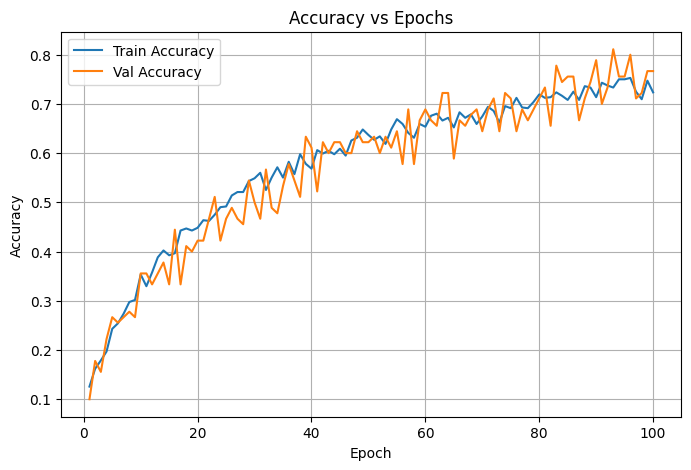

Test Accuracy: 0.6889
Test F1 Score: 0.6994


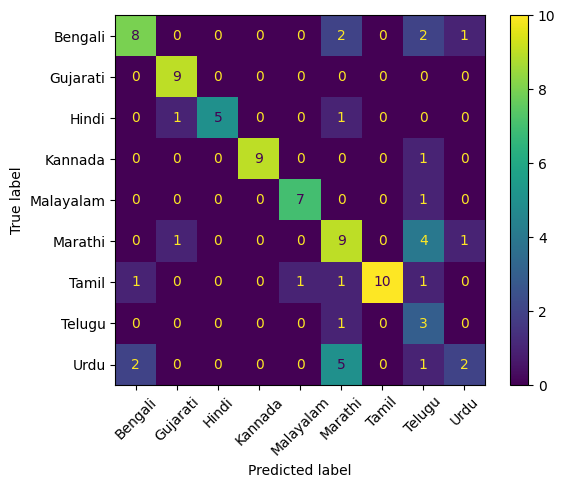

In [ ]:

# Run
model = CNN1D(num_classes=len(label2idx))
train_model(model, train_loader, val_loader, epochs=100)
evaluate_model(model, test_loader)
